In [4]:
pp.ProfileReport(train_df)
# hight corr to drop
# ['153', '165', '180', '9']

# pp.ProfileReport(test_df)

---

In [1]:
# !pip install numpy
# !pip install pandas
# !pip install pandas_profiling
# !pip install sklearn
# !pip install scipy
# !pip install statsmodels

In [2]:
import numpy as np
import pandas as pd           # for reading file
from scipy.stats import rankdata
import pandas_profiling as pp # statistical visualise
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.ensemble import ExtraTreesClassifier


%matplotlib inline

In [3]:
train_df = pd.read_csv('../data/train.csv', index_col='Unnamed: 0', sep='\t')
test_df = pd.read_csv('../data/test.csv', index_col='Unnamed: 0', sep='\t')

print ("rows \t\t: ", train_df.shape[0])
print ("columns \t: ", train_df.shape[1])
# train_df.head(1) , test_df.head(1)

rows 		:  30500
columns 	:  346


In [4]:
def one_hot_encoding(train, test):
    for i in train:
        if len(train[i].unique()) < 15 and len(train[i].unique()) > 1:
            train = pd.concat([train, pd.get_dummies(train[i], prefix=i)], axis=1)
            train.drop(i, axis=1, inplace=True)
            
            test = pd.concat([test, pd.get_dummies(test[i], prefix=i)], axis=1)
            test.drop(i, axis=1, inplace=True)
    return train, test

def    clean_data(train, test):
    columns_name = []

    for i in test:
        if (len(train[i].unique()) == 1):
            columns_name.append(i)
        elif (len(train[i].unique()) == 2) and (len(test[i].unique()) < 2):
            columns_name.append(i)
        elif (len(train[i].unique()) == 2) and min(train[i].value_counts()) / sum(train[i].value_counts()) * 100 < .05:
            columns_name.append(i)
    return columns_name

def get_corr_cols(df, method):
    corr_matrix = df.corr(method=method).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(upper[column] > 0.995)]

---
## 1. Опишите препроцессинг данных, инжиниринг фич и валидацию

#### Разбиваем выборку

In [5]:
X_train = train_df.drop(['0'], axis=1)
y_train = train_df['0']

X_validation = test_df.drop(['0'], axis=1)
y_validation = test_df['0']

#### Удаляем признаки у которых только 1 уникальное значения, и у которых вариабельность меньше 0.5%

In [6]:
clean_columns = clean_data(X_train, X_validation)
X_train.drop(clean_columns, axis=1, inplace=True)
X_validation.drop(clean_columns, axis=1, inplace=True)

#### Кодируем категориальные признаки one_hot_encoding

In [7]:
# X_train, X_validation = one_hot_encoding(X_train, X_validation);
# X_train.drop(list(set(X_train.columns) ^ set(X_validation.columns)), axis=1, inplace=True)

#### Удаляем признаки у которых уровень корреляция больше 99

In [8]:
corr_arr = get_corr_cols(X_train, 'pearson')
X_train.drop(corr_arr, axis=1, inplace=True)
X_validation.drop(corr_arr, axis=1, inplace=True)

In [9]:
print ("Train : ")
print ("\t", X_train.shape)

Train : 
	 (30500, 308)


#### Чистим данные вклад которых в можель не такой большой (для быстроты обработки)

(-1, 154)

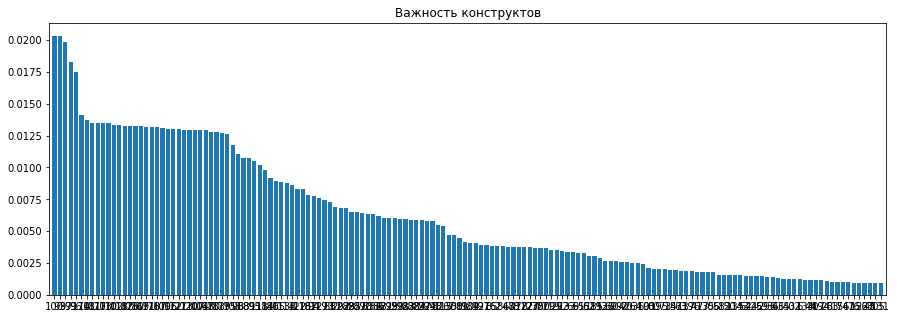

In [10]:
forest = RandomForestRegressor(n_estimators=500, max_features=10,
                                random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = int(len(X_train.columns) / 2)
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]


plt.figure(figsize=(15, 5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])


In [11]:
important_values = zip(X_train.columns, forest.feature_importances_)

to_del = []
for i , j in important_values:
    if j < 0.001:
        to_del.append(i)

X_train.drop(to_del, axis=1, inplace=True)
X_validation.drop(to_del, axis=1, inplace=True)

#### Разбиваем на train и test

In [12]:
from sklearn.model_selection import train_test_split
X_train_1, X_test, y_train_1, y_test = train_test_split(X_train, 
                                                   y_train,
                                                   test_size=0.10, 
                                                   random_state=42,
                                                   stratify=y_train)

---
## 2. Постройте логистическую регрессию. Укажите значение на валидации и публичном лидерборде

In [13]:
print ("Train : ")
print ("\t", X_train_1.shape)
print ("Test : ")
print ("\t", X_test.shape)

Train : 
	 (27450, 144)
Test : 
	 (3050, 144)


In [14]:
log = LogisticRegression(random_state=42, class_weight='balanced')
skf = StratifiedKFold(shuffle=True, n_splits=4, random_state=42)

params = {
    'C' : [.01, .1, .5, 1, 1.5, 2],
    'class_weight' : [None, 'balanced'],
#     'intercept_scaling' : [np.arange(0, 20, 1)],
    'penalty' : ['l1'],
    'tol' : [0.0001, 0.001, 0.002, 0.004]
}

best_params = {
    'C': [0.5], 
    'class_weight': ['balanced'],
    'penalty': ['l1'], 
    'tol': [0.0001]
}

In [15]:
log_reg = GridSearchCV(log, 
                       best_params, 
                       cv=skf, 
                       scoring='roc_auc', 
                       n_jobs=-1, 
                       verbose=2)

log_reg.fit(X_train_1, y_train_1)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV] C=0.5, class_weight=balanced, penalty=l1, tol=0.0001 ............
[CV] C=0.5, class_weight=balanced, penalty=l1, tol=0.0001 ............
[CV] C=0.5, class_weight=balanced, penalty=l1, tol=0.0001 ............
[CV] C=0.5, class_weight=balanced, penalty=l1, tol=0.0001 ............
[CV]  C=0.5, class_weight=balanced, penalty=l1, tol=0.0001, total=  21.2s
[CV]  C=0.5, class_weight=balanced, penalty=l1, tol=0.0001, total=  38.7s
[CV]  C=0.5, class_weight=balanced, penalty=l1, tol=0.0001, total=  47.1s
[CV]  C=0.5, class_weight=balanced, penalty=l1, tol=0.0001, total=  50.1s


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   50.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.5], 'class_weight': ['balanced'], 'penalty': ['l1'], 'tol': [0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [16]:
print (log_reg.best_params_)
print (log_reg.best_estimator_)
print (log_reg.best_score_)
# 0.7291205711899963

{'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l1', 'tol': 0.0001}
LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.719548302053555


In [17]:
pred = log_reg.predict(X_test)

#### Rank local True

In [18]:
roc_auc_score(y_test, pred)

0.6594285739508113

---

In [19]:
solution = pd.DataFrame(log_reg.predict(X_validation))
solution.to_csv('solution.csv')

    Rank site  : 0.67476017
    Rank local : 0.6741615
    С удалением всех коррелирующих переменных : 0.6721678

---
## 3. Постройте бэггинг на логистических регрессиях. Укажите значение на валидации и публичном лидерборде

In [63]:
skf = StratifiedKFold(shuffle=True, n_splits=3, random_state=42)
lg1 = LogisticRegression(class_weight='balanced')

In [21]:
parameters = {
    'max_samples': [.9],
    'max_features': [.74],
#    настройки для каждой лог регрессии
    'base_estimator__C': [.5],
    'base_estimator__class_weight': ['balanced'],
    'base_estimator__penalty': ['l1']
}

In [ ]:
bg = BaggingClassifier(lg1, random_state=42, n_estimators=25)
r_grid_search = RandomizedSearchCV(bg,
                                   parameters,
                                   scoring='roc_auc',
                                   n_iter=1,
                                   cv=skf,
                                   random_state=42,
                                   n_jobs=-1,
                                   verbose=2)

r_grid_search = r_grid_search.fit(X_train_1, y_train_1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_samples=0.9, max_features=0.74, base_estimator__penalty=l1, base_estimator__class_weight=balanced, base_estimator__C=0.5 
[CV] max_samples=0.9, max_features=0.74, base_estimator__penalty=l1, base_estimator__class_weight=balanced, base_estimator__C=0.5 
[CV] max_samples=0.9, max_features=0.74, base_estimator__penalty=l1, base_estimator__class_weight=balanced, base_estimator__C=0.5 


In [ ]:
print(r_grid_search.best_params_)
print(r_grid_search.best_score_)

In [ ]:
pred = r_grid_search.predict(X_test)

#### Rank local 

In [ ]:
roc_auc_score(y_test, pred)

---

In [ ]:
solution = pd.DataFrame(r_grid_search.predict(X_validation))
solution.to_csv('solution.csv')

    Rank site  : 0.66380251
    Rank local : 0.665112231

---
## 4. Постройте случайный лес. Укажите значение на валидации и публичном лидерборде

In [19]:
parameters = {
    'max_features': [30],
    'min_samples_leaf': [7],
    'max_depth': [40]
}

In [20]:
skf = StratifiedKFold(shuffle=True, n_splits=5, random_state=42)
etc = RandomForestClassifier(n_estimators=100, 
                             class_weight='balanced',
                             random_state=42,
                             n_jobs=-1)

gsv = GridSearchCV(etc,
                   parameters,
                   scoring='roc_auc',
                   cv=skf,
                   n_jobs = -1,
                   verbose=1
                   )

gsv.fit(X_train_1, y_train_1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [30], 'min_samples_leaf': [7], 'max_depth': [40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [21]:
print (gsv.best_params_)
print (gsv.best_score_)

{'max_depth': 40, 'max_features': 30, 'min_samples_leaf': 7}
0.7314047968590539


In [22]:
pred = gsv.predict(X_test)

#### Rank local 

In [23]:
roc_auc_score(y_test, pred)

0.6311669815262746

---

In [24]:
X_test.shape, X_validation.shape

((3050, 144), (4166, 144))

In [24]:
solution = pd.DataFrame(gsv.predict(X_validation))
solution.to_csv('solution.csv')

    Rank site  : 0.62453755
    Rank local : 0.63116698

---
## 5. Подберите лучший вариант простого ансамбля. Опишите его и укажите значение на валидации и публичном лидерборде

#### Разбиваем на train и test

In [25]:
from sklearn.model_selection import train_test_split
X_train_1, X_test, y_train_1, y_test = train_test_split(X_train, 
                                                   y_train,
                                                   test_size=0.10, 
                                                   random_state=42,
                                                   stratify=y_train)

### Подбор весов

In [53]:
result = []

weight = .1
best_score = 0.0
for i in np.arange(.05, 1, .05):
    score = roc_auc_score(y_test, i * log_reg.predict_proba(X_test)[:, 1] +
                          (1 - i) * gsv.predict_proba(X_test)[:, 1])
#     print(score)
    if best_score < score:
        best_score = score
        weight = i   

In [29]:
weight, best_score

(0.45, 0.7295076419663719)

In [52]:
test_df['0'] = (weight * log_reg.predict_proba(X_validation)[:, 1] + (1 - weight) * gsv.predict_proba(X_validation)[:, 1])

solution = pd.DataFrame(test_df['0'])
solution.to_csv('solution.csv')
test_df.head()

0  1  2  3  4  5  6         7  8  9 ...        336  337  338  339  \
0  0.343523  1  0  0  1  0  0  0.136364  0  0 ...   0.192984    0    1    0   
1  0.620076  1  0  0  1  0  0  0.181818  0  0 ...   0.195690    0    1    0   
2  0.392091  1  0  0  0  0  0  0.090909  0  0 ...   0.192984    0    1    0   
3  0.531571  1  0  0  1  0  0  0.090909  0  0 ...   0.195690    0    1    0   
4  0.790333  1  0  0  1  0  0  0.090909  0  0 ...   0.289893    0    0    1   

   340       341  342  343  344  345  
0    0  0.222222    1    1    1    1  
1    0  0.000000    1    1    1    0  
2    0  0.222222    1    1    1    0  
3    0  0.000000    1    1    1    0  
4    0  0.000000    1    1    1    1  

[5 rows x 346 columns]

    Rank site  : 0.74480024
    Rank local : 0.72950764

---
## 6. Сделайте стекинг. Опишите его и укажите значение на валидации и публичном лидерборде

---
## 7. Укажите ваш ник, значение на lb и валидации, опишите коротко решение